In [37]:
%run synthetic_fit_funcs.py

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb

In [4]:
def unweight(net,thr):
    return np.sign(net)*(abs(net) >= thr)

def topQnet(net_o,q=0.9):
    net = net_o.copy()
    if isinstance(net,pd.DataFrame):
        net = net.values
    qstr = np.quantile(np.abs(np.tril(net,k=-1).flatten()),q)
    net = net - np.diag(np.diag(net))
    return unweight(net,qstr)

# Generating Synthetic Data From Log-Normal Distribution with Error-Free Simulated Reads

We start with setting up our parameters:

In [5]:
network_methods = ["Log Covariance","CLR Mixed","CLR Split","SparCC","GLASSO Mixed","GLASSO Split"]

ns = 2 # 2 for data split in half. Can also split more times...
gsp = 0.05 #approximate graph sparsity desired

grmod = "PL"#power-law clustering graph


mean_spread = 4 #for choosing the mean of the log-data higher for larger spread (e.g. more rare & dominant taxa)
mean_center = 0 #to center things around 1

min_var = 0.3 #minimum variance of log-abundance for each taxa
max_var = 2 #maximum variance of log-abundance for each taxa

simulate_reads_tasks = 6 #how many cores to use for parallel computing

avgdpth = 100000 #average read depth
stddpth = 10000 #standard deviation in read depth

Including number of taxa and number of samples

In [6]:
M = 150 ###Samples
N = 500 ###Taxa

In [102]:
sparse_adjust = {"Kingdoms":(0,1),"SparsityRatio":0.1}
bias_blocks = [(0,1,1)] #cross kingdom interactions more positive
bias_str = 0.2 #but not a lot more.

## A function to do it all:

The ```generate_synthetic_data``` function creates the synthetic data set that can be fed into network algorithms such as SparCC or GLASSO (one can use SpiecEasi: https://github.com/zdk123/SpiecEasi)

In [103]:
kwargs = {
    'max_variance':max_var,
    'min_variance':min_var,
    'data_types':ns,
    'graph_model':grmod,
    'sparsity':gsp,
    'mean_log_range':mean_spread,
    'mean_log_center':mean_center,
    'simulate_reads_tasks':simulate_reads_tasks,
    'average_read_depth':avgdpth, 
    'std_of_read_depth':stddpth,
    'truth_sparsity_adjustment':sparse_adjust,
    'truth_bias_strength':bias_str,
    'truth_bias_structure':bias_blocks
}
synthetic_data = generate_synthetic_data(N,M,**kwargs)

 25%|██▌       | 47/186 [00:00<00:00, 469.22it/s]

[create_groundtruth_covariance] Generating cholesky decomposition


  2%|▏         | 3/150 [00:00<00:06, 24.15it/s]

[generate_synthetic_samples] Drawing 150 Samples for 500 taxa


100%|██████████| 150/150 [00:06<00:00, 22.97it/s]

[simulate_all_reads] Drawing Read Assignments for 186 taxa, 150 samples.


[simulate_all_reads] Drawing Read Assignments for 314 taxa, 150 samples.


### What does it give us?

In [7]:
synthetic_data.keys()

dict_keys(['GroundTruthCovariance', 'GraphSparsity', 'AbsoluteSamples', 'CombinedReads', 'SeparatedReads', 'GroupOrder', 'ReadDepths', 'TotalRatioVariance', 'DataSplit'])

The ``DataSplit`` field tells us where our first group (e.g. bacteria) ends our second begins:

In [8]:
synthetic_data['DataSplit']

array([  0, 500])

In [11]:
synthetic_data["SeparatedReads"].keys()

dict_keys(['Set1'])

The ```GroundTruthCovariance``` field gives the covariance matrix used to generate the data. Below, we show the positive/negative entry pattern for this matrix, with the diagonal removed (and ignoring magnitude). Blue dots represent positive interactions and red represent negative. The black lines indicate the two data sets, so the top left box is intra-kingdom 1, the bottome right is intra-kingdom 2, and the off-diagonal blocks are cross-kingddom edges.

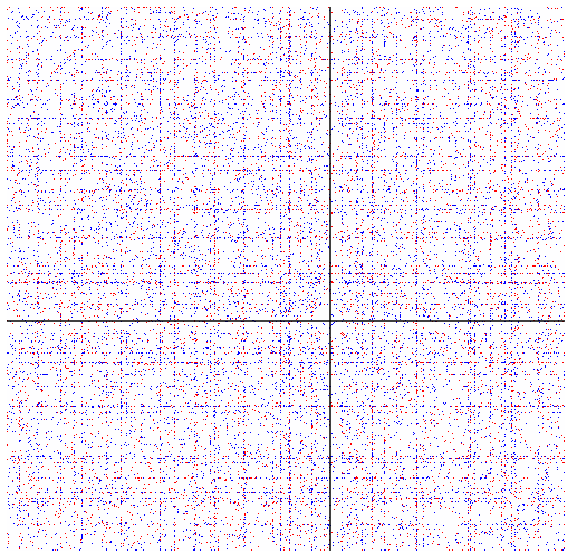

In [9]:
fig,ax = plt.subplots(figsize = (10,10))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(synthetic_data["GroundTruthCovariance"].round(8),q = 0),cmap = "bwr_r",cbar = False,ax = ax,center = 0)
ax.plot([0,1000],[synthetic_data['DataSplit'][1],synthetic_data['DataSplit'][1]],color = 'k')
ax.plot([synthetic_data['DataSplit'][1],synthetic_data['DataSplit'][1]],[0,1000],color = 'k')

ax.set_xticks([])
ax.set_yticks([]);

The ```GraphSparsity``` field tells us the proportion of nonzero entries in the ground truth covariance matrix. This represents the proportion of pairs of taxa that interact in our simulated environment.

In [10]:
synthetic_data['GraphSparsity']

0.07219238476953908

The ```AbsoluteSamples``` field contains the table of synthetic absolute abundances of each taxa (rows) in each sample (columns) that was simulated. These are drawn from a log-normal distribution, meaning that all taxa are present in every sample, but many at a very low abundance. This data is not possible to collect in the real world. Note that taxa are simply numbered from 0 to N-1.

In [11]:
synthetic_data['AbsoluteSamples'].head(10)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S140,S141,S142,S143,S144,S145,S146,S147,S148,S149
0,0.597648,1.772386,0.086152,0.016232,0.013310,0.279785,0.012996,0.336621,0.337851,0.018668,...,0.250025,0.337306,0.244113,0.197593,1.181065,0.170122,5.476950,0.537223,1.483248,0.514340
1,0.150322,0.179117,0.445542,0.728705,0.350534,0.556499,0.601507,0.401279,0.336021,0.281731,...,0.298823,0.121988,0.535584,0.927030,0.103231,0.102696,0.160277,0.359339,0.166841,0.459350
2,14.705268,1.520322,16.781506,167.150705,64.954032,8.992992,32.382227,11.444839,3.242654,79.837433,...,5.767777,13.236715,0.770819,3.725300,2.952364,6.091066,0.280061,3.563015,1.031971,1.445329
3,0.386642,0.972088,0.347322,0.021089,0.009358,0.173786,0.228262,1.211787,3.219331,0.058888,...,0.275193,0.317866,0.004523,0.060027,0.938261,0.861969,0.092488,0.349459,0.523742,2.476811
4,8.959537,2.519566,3.632469,4.547272,9.834568,7.112194,5.749603,5.329285,4.676063,1.789155,...,2.540449,16.518527,5.104592,4.314518,7.056194,4.725241,8.784082,6.700828,9.771051,9.096123
5,0.326215,0.155910,0.049737,0.126479,0.148156,0.363537,0.278733,0.388261,0.630893,0.105287,...,0.053422,0.299581,0.795953,0.125972,0.755448,0.411168,0.338841,0.115992,0.696226,0.141046
6,0.771228,0.054725,1.582394,0.827469,0.379098,0.949224,0.941500,1.187342,0.958173,1.788030,...,0.626458,2.242120,0.406416,0.760765,0.242822,0.647181,0.144120,0.415082,0.616609,1.487091
7,0.153382,1.084383,0.243562,0.143431,0.710488,0.577277,0.962030,0.287637,0.361357,0.564960,...,0.479096,0.247987,0.663832,0.821005,0.384730,0.526503,0.193900,0.261882,2.048832,0.146025
8,1.668019,1.767557,4.996376,3.558445,2.449366,6.116919,2.667647,2.559320,2.543906,4.085527,...,5.005746,3.180308,3.823386,3.142093,3.036233,4.939785,3.516964,2.731985,3.166051,3.633124
9,0.231750,0.204784,0.912699,0.381399,0.264659,0.351432,0.452271,0.632907,0.194025,3.074269,...,0.405503,0.086439,0.111314,0.630025,0.035865,0.049181,0.095498,0.232450,0.713750,0.049214


The ```CombinedReads``` field contains a single table of simulated read counts for the entire combined (paired) data-set. This would be the result of concatenating e.g. the outputs of 16S sequencing and ITS sequencing.

In [12]:
synthetic_data['CombinedReads'].head(10)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S140,S141,S142,S143,S144,S145,S146,S147,S148,S149
0,75,107,6,1,2,3,1,31,18,0,...,10,15,25,13,87,11,715,38,92,49
1,16,11,38,57,20,24,61,25,24,11,...,16,10,59,28,5,10,16,20,4,46
2,2089,101,1508,14222,5203,398,3089,810,185,2209,...,218,845,98,116,203,342,38,277,49,157
3,50,60,27,2,1,14,23,79,189,1,...,9,17,0,1,65,54,14,17,28,230
4,1280,140,274,377,800,275,539,387,269,56,...,127,995,580,108,541,277,1106,508,589,874
5,43,13,6,11,7,16,30,29,34,1,...,0,18,95,3,71,16,47,8,35,15
6,87,5,127,61,36,39,90,74,61,36,...,24,134,61,16,16,34,22,31,39,147
7,22,60,17,12,69,16,83,12,21,7,...,24,19,79,15,33,29,18,16,121,14
8,236,99,452,336,197,234,258,176,140,119,...,199,170,464,76,231,312,394,178,184,364
9,35,15,95,24,16,9,41,31,8,79,...,15,9,11,21,1,5,12,21,52,5


The ```SeparatedReads``` field contains a dictionary of the separate read counts for the two sets of taxa (e.g. bacteria and fungi). These would be the result of separate 16S and ITS sequencing. Note that taxa labels are consistent, so the first set is numbered 0 to M-1 and the second is numbered M to N, where M is the number of taxa in the first set and N is the total number of taxa.

In [13]:
synthetic_data['SeparatedReads'].keys()

dict_keys(['Set1', 'Set2'])

In [14]:
synthetic_data['SeparatedReads']['Set1'].head(10)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S140,S141,S142,S143,S144,S145,S146,S147,S148,S149
0,75,107,6,1,2,3,1,31,18,0,...,10,15,25,13,87,11,715,38,92,49
1,16,11,38,57,20,24,61,25,24,11,...,16,10,59,28,5,10,16,20,4,46
2,2089,101,1508,14222,5203,398,3089,810,185,2209,...,218,845,98,116,203,342,38,277,49,157
3,50,60,27,2,1,14,23,79,189,1,...,9,17,0,1,65,54,14,17,28,230
4,1280,140,274,377,800,275,539,387,269,56,...,127,995,580,108,541,277,1106,508,589,874
5,43,13,6,11,7,16,30,29,34,1,...,0,18,95,3,71,16,47,8,35,15
6,87,5,127,61,36,39,90,74,61,36,...,24,134,61,16,16,34,22,31,39,147
7,22,60,17,12,69,16,83,12,21,7,...,24,19,79,15,33,29,18,16,121,14
8,236,99,452,336,197,234,258,176,140,119,...,199,170,464,76,231,312,394,178,184,364
9,35,15,95,24,16,9,41,31,8,79,...,15,9,11,21,1,5,12,21,52,5


In [15]:
synthetic_data['SeparatedReads']['Set2'].head(10)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S140,S141,S142,S143,S144,S145,S146,S147,S148,S149
289,2214,2210,12,237,21,110,210,56,74,169,...,1258,1285,2,743,419,530,56,63,5687,873
290,21,35,26,51,22,26,23,12,15,31,...,17,26,19,40,16,97,28,13,53,16
291,1002,360,406,653,49,426,721,1349,4502,58,...,647,3241,385,262,805,1337,656,2882,519,1663
292,804,636,2335,236,5252,2355,892,697,512,411,...,168,103,279,513,265,3004,3277,1413,361,279
293,540,264,273,113,1426,440,576,4525,13,190,...,266,586,405,1210,2161,5349,465,800,2160,94
294,181,255,9,163,112,19,96,246,1374,223,...,27,456,73,64,58,530,53,3991,166,397
295,419,14,31,107,6,65,22,31,17,18,...,45,77,3,9,32,31,17,59,3,2
296,16,20,11,48,21,25,10,9,14,23,...,23,29,18,32,3,23,33,37,15,33
297,15,63,34,0,51,17,10,7,3,21,...,18,5,9,19,8,20,50,51,3,10
298,335,407,253,944,1101,1236,708,656,784,576,...,742,259,228,497,230,2889,512,735,337,1585


The ```GroupOrder``` field contains a list of the data ranges for each set, in order.

In [16]:
synthetic_data['GroupOrder']

[(0, 289), (289, 500)]

The ```ReadDepths``` field contains a dictionary of arrays that tell us the total number of reads used for each sample for each data set. Note that this can also be obtained by ```synthetic_data['SeparatedReads']['Set1'].sum()```.

In [17]:
synthetic_data['ReadDepths'].keys()

dict_keys(['Set1', 'Set2'])

In [18]:
synthetic_data['ReadDepths']["Set1"]

array([100556,  83408,  95764,  94447,  89670,  99276, 110791,  97765,
       108342,  94356, 108152, 106211, 102671,  91856,  89436,  91827,
        98290,  86616, 108619, 116247,  97304,  93325, 110823,  90344,
       112823,  91685,  87262,  97419,  94724, 104961, 113926,  97472,
       107211, 106576, 110312, 103340, 100536,  94843,  84703, 110298,
        99214, 109402,  97679, 112853,  84702, 110742,  92355, 116448,
       114844,  78012,  87779, 100366, 106154,  84694,  94185, 100385,
       109784,  96418, 103037,  88047, 106962, 103130,  96585,  86637,
       109265,  95193,  92409,  97329, 101282, 110262, 102114,  94592,
       112847,  93855, 106244, 105576,  91886, 103293, 119527,  94773,
        93561, 107198,  93631, 123951, 104291, 108323,  95682, 105024,
       100161, 102140,  88099,  97125,  89011,  91187, 110124,  80593,
        92845,  88865,  98241, 105101,  86930, 105049, 116006, 113055,
       102473, 108726,  91735,  98740,  91813,  91004, 106004, 109785,
      

In [19]:
synthetic_data['ReadDepths']["Set2"]

array([103428,  79316, 104891, 103981,  92478, 100087,  91900,  88957,
        92002,  90433, 106886, 118381,  97833,  93737, 103229, 114683,
        95685, 106316, 108539, 106980, 100103,  86865, 103616, 105131,
       105500, 106553,  89874,  91342,  94519, 108881, 103530,  97336,
        80539,  89879,  82280,  85308, 108803, 108576,  92946, 113753,
       111785, 107142,  94622, 107977, 107051,  99262, 120454, 105561,
       123296, 114425, 109240,  98467, 109512, 112592, 103129, 103217,
       102319, 110055, 113515,  94558,  99875, 109595,  85875,  83359,
       109069, 103322, 103169, 107407, 107857, 107536,  91751, 101002,
        96638,  94982, 109254, 102538, 103002,  88090, 101005, 107055,
       107204, 122157, 102411, 102913,  91616, 103424, 106929,  95509,
        98863, 107197,  91008, 106785,  88738, 101296, 109401, 121217,
        98359, 106235,  83447, 107122, 110008,  93024,  94472,  95188,
        86214, 107689, 111878,  98250,  97878,  86574,  98452,  89272,
      

The ```TotalRatioVariance``` field contains the variance of the ratio of (total absolute abundance in kingdom 1)/(total absolute abundance in kingdom 2) across samples. This quantity plays a large role in the error of network inference with concatenated data.

In [20]:
synthetic_data['TotalRatioVariance']

1.375108787486058

## What's going on under the hood?

To demonstrate how the data is generated, the following is a step-by-step version of what the ```generate_synthetic_data``` does.

The first task is to generate a covariance matrix. That process can be broken into a few steps:

First, we use NetworkX to generate a graph structure for the community. This will be the sparsity (0 entries) structure of our covariance matrix.

In [7]:
nedges = gsp*(N**2)
p = 0.3
K = max(int(nedges/(N*(1+p))),1)
graph = nx.powerlaw_cluster_graph(N, K, p)

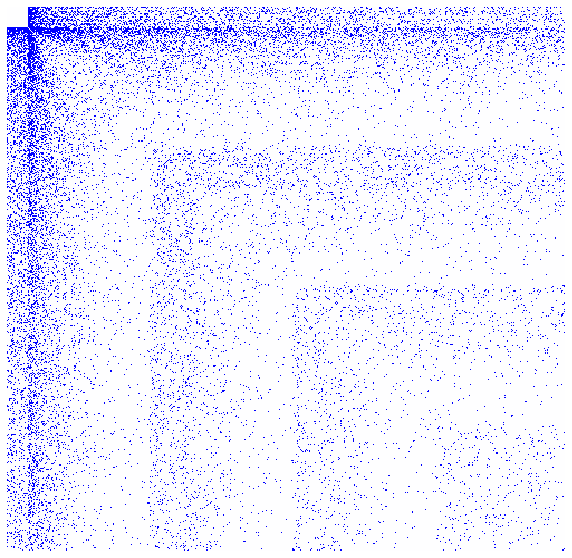

In [8]:
fig,ax = plt.subplots(figsize = (10,10))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(nx.to_numpy_array(graph),cmap = "bwr_r",cbar = False,center = 0)

ax.set_xticks([])
ax.set_yticks([]);

Next, we shuffle the labels of this graph, so that edges and clusters are evenly distributed between the two kingdoms:

In [9]:
Adj = nx.to_numpy_array(graph)
sh = np.random.permutation(N)
shffld = Adj[sh][:,sh]

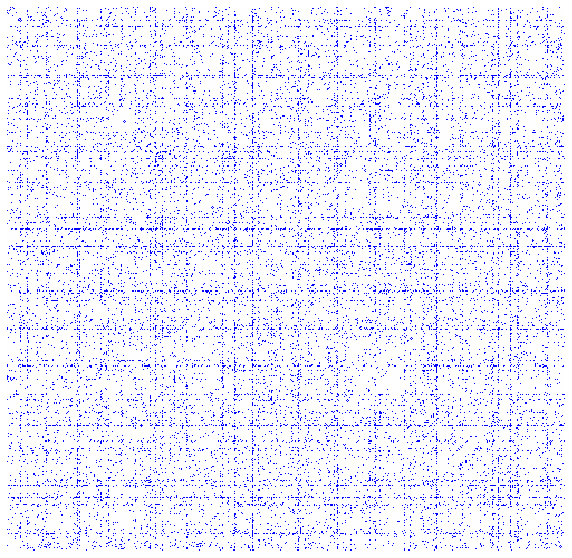

In [10]:
fig,ax = plt.subplots(figsize = (10,10))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(shffld,cmap = "bwr_r",cbar = False,center = 0)

ax.set_xticks([])
ax.set_yticks([]);

Next we choose which taxa belong to which kingdom. Notice that our model assumes that covariances across kingdoms and within kingdoms are evenly distributed. In other words, it assumes that the only distinction between kingdoms is in how abundances are measured. To change this, one could use a different method of constructing the underlying covariance matrix (e.g. by choosing one kingdom's intra-kingdom edges to be denser than the others). We have not implemented this functionality. 

In [11]:
minsplit = int(0.2*N)
maxsplit = int(0.8*N)
splits = np.sort(np.random.choice(range(minsplit,maxsplit),size = ns-1,replace = False))

spl_i = np.concatenate([[0],splits,[N]])

In [12]:
spl_i

array([  0, 237, 500])

If we want more or less cross-kingdom edges (regardless of sign), we can add or remove edges now. We are going to design a method to give us a desired sparsity relative to the interkingdom edges.

In [13]:
sparse_adjust = {"Kingdoms":(0,1),"SparsityRatio":0.1}

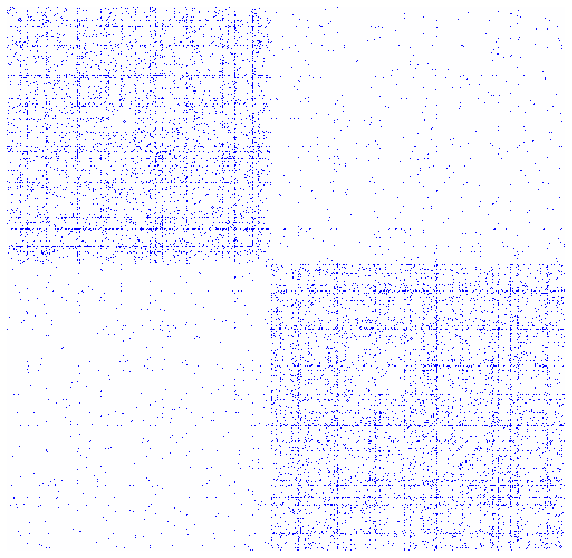

In [15]:
shffld = adjust_sparsity(sparse_adjust,shffld,spl_i)

fig,ax = plt.subplots(figsize = (10,10))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(shffld,cmap = "bwr_r",cbar = False,center = 0)

ax.set_xticks([])
ax.set_yticks([]);

And compute the sparsity:

In [16]:
Sp = shffld.sum()/(N*(N-1))
Sp

0.04023246492985972

Next we generate a positive definite matrix with the same 0 pattern and both positive and negative real-valued (non-integer) values. To do so, we iterate through the nodes of the above graph choosing a random vector for each. For each node, we choose a random vector that is perpendicular to the vector for previous nodes which do not have an edge to the current node. We call this collection ```Q```. Then the product ```QQ^T``` is a positive definite matrix with the desired sparsity pattern.

We can furthermore choose vectors with only negative/positive interactions, or biased toward positive/negative interactions, by computing the dual cone of the vectors we want a positive interaction with (or polar cone of those we want a negative interaction with).

In [18]:
Q = (min_var + (max_var-min_var))*np.random.rand()*np.eye(N)

for i in tqdm(range(1,spl_i[1])):
    Q[i] = rand_in_perp(Q[:i][~shffld[i,:i].astype(bool)],mxvars = max_var,minvars = min_var)
for i in tqdm(range(spl_i[1],N)):
    Q[i] = rand_in_perp(Q[:i][~shffld[i,:i].astype(bool)],mxvars = max_var,minvars = min_var,bias = 1, neg = Q[:spl_i[1]][shffld[i,:spl_i[1]].astype(bool)])
covar = np.dot(Q,Q.T)

100%|██████████| 263/263 [00:13<00:00, 19.47it/s]


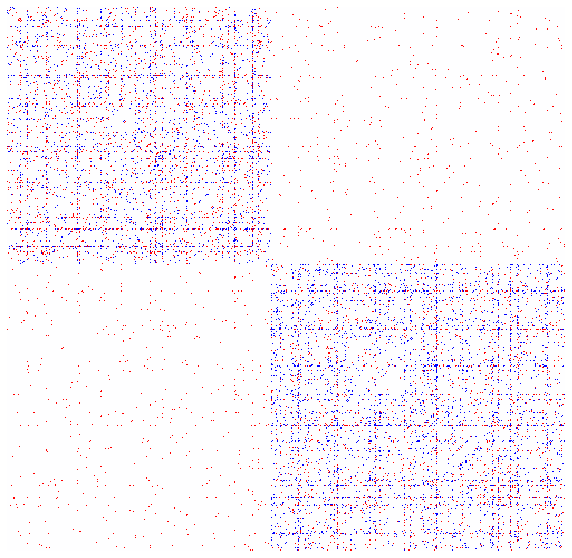

In [19]:
fig,ax = plt.subplots(figsize = (10,10))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(covar.round(8),q = 0),cmap = "bwr_r",cbar = False,ax = ax,center = 0)

ax.set_xticks([])
ax.set_yticks([]);

The function that combines these steps is ```create_groundtruth_covariance```

In [97]:
%run synthetic_fit_funcs.py

In [98]:
covar_matrix, actual_sparsity = create_groundtruth_covariance(N,grmod,gsp,spl_i,mxvars=max_var,minvars=min_var,bias_blocks=None,bias_str=0.8,sparse_adjust = sparse_adjust)

 20%|██        | 48/237 [00:00<00:00, 474.37it/s]

[create_groundtruth_covariance] Generating cholesky decomposition


100%|██████████| 263/263 [00:06<00:00, 39.70it/s]


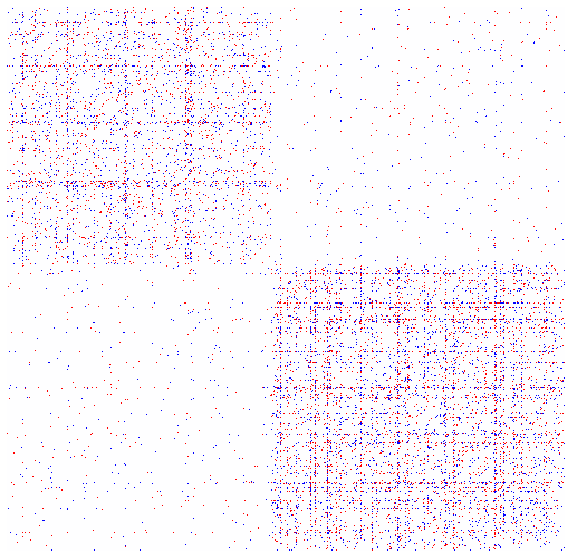

In [99]:
fig,ax = plt.subplots(figsize = (10,10))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(covar_matrix.round(8),q = 0),cmap = "bwr_r",cbar = False,ax = ax,center = 0)

ax.set_xticks([])
ax.set_yticks([]);

<AxesSubplot:xlabel='Block', ylabel='Edge'>

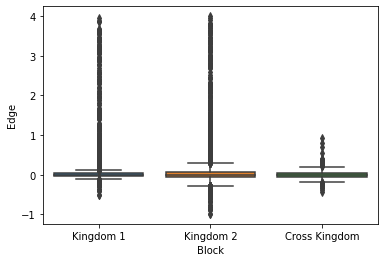

In [100]:
kingdom1 = covar_matrix[:spl_i[1],:spl_i[1]].flatten()
kingdom2 = covar_matrix[spl_i[1]:,spl_i[1]:].flatten()
Xkingdom = covar_matrix[:spl_i[1],spl_i[1]:].flatten()
alledges = pd.DataFrame(np.array([np.concatenate([kingdom1,kingdom2,Xkingdom]).round(5),["Kingdom 1"]*len(kingdom1)+["Kingdom 2"]*len(kingdom2) + ["Cross Kingdom"]*len(Xkingdom)]).T)
alledges.columns = ["Edge","Block"]
alledges['Edge'] = alledges['Edge'].astype(float)
sb.boxplot(data = alledges[alledges["Edge"] != 0],y = "Edge",x = "Block")

Next we generate synthetic "true" taxa abundance for each sample, simply by drawing from a log-normal distribution. This is achieved by the ```generate_synthetic_samples``` function, which also randomly draws a vector of mean abundances.

In [30]:
absolute_abundance,_ = generate_synthetic_samples(M,covar_matrix,mean_log_range = mean_spread,mean_log_center = mean_center)

  0%|          | 0/150 [00:00<?, ?it/s]

[generate_synthetic_samples] Drawing 150 Samples for 500 taxa


100%|██████████| 150/150 [00:07<00:00, 20.79it/s]


In [31]:
absolute_abundance.head(10)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S140,S141,S142,S143,S144,S145,S146,S147,S148,S149
0,0.379329,2.125491,2.087712,2.870420,1.025765,8.565928,3.916336,3.530386,1.530494,0.846550,...,3.794360,2.912683,3.019321,1.806374,0.900212,0.673878,1.187524,1.358361,2.597537,1.725046
1,0.606003,0.472983,0.748652,0.844993,0.811071,0.254297,0.499367,0.768882,1.135604,0.800742,...,0.215083,0.286355,0.796666,0.956499,0.507093,1.484827,0.373214,1.004456,0.679736,0.395961
2,4.107036,0.102662,1.922574,1.897140,0.682537,3.549243,0.688963,2.903978,1.154619,1.427763,...,0.464980,0.327778,0.429561,0.518806,0.361605,0.840107,1.703427,1.425120,0.348373,0.317244
3,6.692157,4.491721,3.877759,1.356590,0.385702,0.841109,29.725924,7.645719,6.129338,19.808591,...,0.530737,6.102039,0.667189,4.684959,2.038564,2.115949,0.459974,168.848143,3.779399,6.046556
4,16.709248,0.022348,1.264393,3.315478,2.114878,3.942100,1.389129,10.902011,3.216001,46.565404,...,0.218428,5.136035,0.334521,3.747675,1.484503,1.304837,2.944983,11.822386,0.050060,1.116997
5,0.425714,0.534419,0.194598,0.019526,0.216504,0.078877,0.200825,0.253237,0.075903,0.303022,...,0.456816,0.088400,0.318658,0.305282,0.408376,0.041530,0.104344,0.335817,0.379958,0.046544
6,0.437613,0.429766,1.107128,0.024244,0.474435,0.052009,0.212094,0.153046,0.685267,0.613585,...,0.054376,0.031470,0.348879,0.211941,0.387865,0.014087,0.253319,0.281008,0.148084,0.003836
7,0.061665,0.070004,0.169772,0.049300,0.306526,0.123650,0.170888,0.355494,0.085903,0.138304,...,0.116080,0.268594,0.147052,0.447942,0.113942,0.430175,0.493937,0.182145,0.343693,0.212337
8,0.342766,0.255247,0.625034,0.354473,1.126406,0.244788,0.432171,1.099352,0.428398,0.383964,...,0.435375,0.499546,0.489049,0.832218,0.295888,1.440390,0.688297,0.777424,0.822837,0.497085
9,46.255221,7.305433,2.136083,94.906857,1.707727,105.494660,5.501264,7.603232,11.526338,106.255588,...,2.722999,12.253605,3.576081,0.804224,10.448227,59.698819,41.118459,3.446718,8.427583,5.241904


Next we choose which taxa belong to which kingdom. Notice that our model assumes that covariances across kingdoms and within kingdoms are evenly distributed. In other words, it assumes that the only distinction between kingdoms is in how abundances are measured. To change this, one could use a different method of constructing the underlying covariance matrix (e.g. by choosing one kingdom's intra-kingdom edges to be denser than the others). We have not implemented this functionality. 

In [32]:
minsplit = int(0.2*N)
maxsplit = int(0.8*N)
splits = np.sort(np.random.choice(range(minsplit,maxsplit),size = ns-1,replace = False))

spl_i = np.concatenate([[0],splits,[N]])

Finally, we simulate generating reads for each data type. This process is slow, so we run in parallel with the ```simulate_all_reads``` function. Each read for each sample for each data type is accomplished by drawing from the distribution defined by the true relative abundances (within a kingdom) of the sample.

In [33]:
read_depths = {}
sep_reads = {}
reads_order = []
combined_reads = pd.DataFrame()
for j in range(1,ns+1):
    dpths = np.random.normal(avgdpth,stddpth,size = M).astype(int)
    read_depths["Set{}".format(j)] = dpths
    rd = simulate_all_reads(absolute_abundance.iloc[spl_i[j-1]:spl_i[j]],dpths,nj = simulate_reads_tasks)
    sep_reads["Set{}".format(j)] = rd
    reads_order += [(spl_i[j-1],spl_i[j])]
    combined_reads = pd.concat([combined_reads,rd])

[simulate_all_reads] Drawing Read Assignments for 133 taxa, 150 samples.
[simulate_all_reads] Drawing Read Assignments for 367 taxa, 150 samples.


In [34]:
sep_reads["Set1"].head(10)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S140,S141,S142,S143,S144,S145,S146,S147,S148,S149
0,80,669,524,385,70,745,988,414,247,143,...,406,408,778,171,194,98,391,148,610,430
1,110,154,208,110,58,20,140,76,173,184,...,19,40,210,88,133,212,134,100,170,105
2,734,31,487,240,40,267,140,334,184,256,...,55,45,86,47,71,118,613,173,77,87
3,1189,1435,1006,176,28,58,7414,929,1012,3737,...,69,829,185,437,489,351,149,18581,925,1504
4,2936,9,323,444,177,319,332,1299,515,9126,...,24,679,79,342,312,198,1002,1275,8,303
5,73,151,52,4,18,10,54,28,11,55,...,45,11,67,27,104,1,48,49,105,12
6,86,134,296,4,41,8,51,21,106,121,...,5,0,99,19,81,3,99,22,36,0
7,17,21,51,6,18,11,53,42,8,29,...,11,30,35,28,32,59,174,21,99,60
8,65,88,155,59,84,22,105,139,68,104,...,46,67,127,92,78,200,232,81,191,113
9,8136,2259,554,13114,110,8760,1383,889,1814,20672,...,253,1617,910,83,2279,9024,14239,376,2099,1300


In [35]:
sep_reads["Set2"].head(10)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S140,S141,S142,S143,S144,S145,S146,S147,S148,S149
133,76,24,56,66,64,34,26,86,25,106,...,61,21,43,38,101,12,25,58,7,38
134,4,43,0,4,4,8,12,33,19,287,...,18,7,9,2,11,1,20,10,6,3
135,46,19,8,52,13,7,8,3,4,11,...,14,22,22,17,0,73,56,14,7,26
136,431,73,184,319,226,812,141,233,201,475,...,1912,314,516,241,361,640,230,576,134,121
137,78,122,83,275,102,49,66,137,132,109,...,145,71,108,153,84,116,153,43,92,108
138,56,111,3,66,36,6,125,7,24,139,...,265,7,130,56,129,15,1,51,12,20
139,314,13,92,85,33,116,56,35,22,77,...,30,47,179,178,81,13,74,47,312,57
140,26,116,84,117,275,38,45,56,33,12,...,127,60,68,225,269,57,32,112,21,50
141,72,262,241,305,81,284,302,189,108,126,...,186,96,143,119,366,301,207,281,56,208
142,0,29,19,0,6,1,187,19,0,28,...,21,1,2,12,1,5,67,105,128,1
